In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, PredefinedSplit
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
data = pd.read_csv("/Users/nzaramakouadio/Documents/Duke Classes/Spring 2025/ML/IDS705_MachineLearning_Project/10_Data_Clean/xgboost_data.csv")

In [3]:
data.head()

,Median_Household_Income,Total_Population,PRICE,Avg_Household_Size,Gini_Index,ZIP_CODE,YEAR,Employment_Rate,Below_Poverty_Rate,Rate_College_or_Higher,...,FIRE_LAST_YEAR,FIRE_SHOCK,YEAR_OF_LAST_FIRE,YEARS_SINCE_LAST_FIRE,CUMULATIVE_ACRES_BURNED_LAST_3YRS,FIRE_EXPOSED_x_PRICE_CHANGE_LAG1,MAX_PCT_ZIP_BURNED_x_ROLLING_1yr_PRICE_CHANGE,FIRE_EXPOSED_x_Median_Household_Income,FIRE_EXPOSED_x_Below_Poverty_Rate,ROLLING_3yr_PRICE_CHANGE_STD
0,35658.0,54480,263100.0,4.24,0.4056,90001,2012,89.369276,30.632127,16.684648,...,0,0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.000000
1,35097.0,54760,249600.0,4.23,0.4108,90001,2013,87.745738,32.055698,17.057243,...,0,0,NaN,NaN,0.0,-0.0,0.0,0.0,0.0,0.000000
2,34050.0,56314,241800.0,4.22,0.4181,90001,2014,87.023960,33.644361,18.102684,...,0,0,NaN,NaN,0.0,-0.0,0.0,0.0,0.0,1.418547
3,33887.0,57227,258500.0,4.25,0.4223,90001,2015,87.329232,32.517250,17.484799,...,0,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,6.449310
4,34323.0,57942,272200.0,4.26,0.4224,90001,2016,87.720183,32.676417,18.821322,...,0,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,5.388114


In [4]:

###########################################
# Subset X and Y features
###########################################

# Select our Y target variable
y = data["PCT_PRICE_CHANGE (%)"]

# Select our X features

# Columns to drop from X
col_drop = ["PCT_PRICE_CHANGE (%)", "PRICE", "NEXT_YEAR_PRICE", "PRICE_CHANGE"]

# Features
X = data.drop(columns=col_drop)

In [5]:
data.columns

Index(['Median_Household_Income', 'Total_Population', 'PRICE',
       'Avg_Household_Size', 'Gini_Index', 'ZIP_CODE', 'YEAR',
       'Employment_Rate', 'Below_Poverty_Rate', 'Rate_College_or_Higher',
       'Black_Portion', 'White_Portion',
       'American_Indian_and_Alaska_Native_Portion', 'Asian_Portion',
       'NUM_FIRES', 'TOTAL_ACRES_BURNED_IN_ZIP', 'AVG_FIRE_DURATION_DAYS',
       'MAX_PCT_ZIP_BURNED', 'ANY_MAJOR_FIRE', 'FIRE_EXPOSED',
       'NEXT_YEAR_PRICE', 'PRICE_CHANGE', 'PCT_PRICE_CHANGE (%)',
       'ROLLING_1yr_PRICE_CHANGE', 'HOME_PRICE_LAG1', 'PRICE_CHANGE_LAG1',
       'PRICE_CHANGE_DIFF', 'PREV_MAX_PCT_ZIP_BURNED', 'FIRE_LAST_YEAR',
       'FIRE_SHOCK', 'YEAR_OF_LAST_FIRE', 'YEARS_SINCE_LAST_FIRE',
       'CUMULATIVE_ACRES_BURNED_LAST_3YRS', 'FIRE_EXPOSED_x_PRICE_CHANGE_LAG1',
       'MAX_PCT_ZIP_BURNED_x_ROLLING_1yr_PRICE_CHANGE',
       'FIRE_EXPOSED_x_Median_Household_Income',
       'FIRE_EXPOSED_x_Below_Poverty_Rate', 'ROLLING_3yr_PRICE_CHANGE_STD'],
      dty

In [6]:
###########################################
# DETREND USING LINEAR REGRESSION
###########################################

from sklearn.linear_model import LinearRegression

# Step 1: Fit a simple time trend
trend_model = LinearRegression()
trend_model.fit(data[["YEAR"]], data["PCT_PRICE_CHANGE (%)"])

# Step 2: Predict the general trend
predicted_trend = trend_model.predict(data[["YEAR"]])

# Step 3: Subtract the trend to create detrended target
data["PCT_PRICE_CHANGE_DETRENDED (%)"] = data["PCT_PRICE_CHANGE (%)"] - predicted_trend

# Optional: Check quickly
print(data[["YEAR", "PCT_PRICE_CHANGE (%)", "PCT_PRICE_CHANGE_DETRENDED (%)"]].head())



   YEAR  PCT_PRICE_CHANGE (%)  PCT_PRICE_CHANGE_DETRENDED (%)
0  2012             -5.131129                       -5.231345
1  2013             -3.125000                       -4.397758
2  2014              6.906534                        4.461235
3  2015              5.299807                        1.681965
4  2016             12.233652                        7.443268


In [7]:
###########################################
# UPDATE TARGET VARIABLE TO DETRENDED PCT PRICE CHANGE
###########################################

# Instead of this:
# y = data["PCT_PRICE_CHANGE (%)"]

# Now do this:
y = data["PCT_PRICE_CHANGE_DETRENDED (%)"]


In [8]:
#########################################
# Divide Dataset for Scaled (Time-based split)
#########################################

# Step 0: Sort data by YEAR
X['YEAR'] = X['YEAR'].astype(int)  # Make sure YEAR is int
X = X.sort_values(by='YEAR')
y = y.loc[X.index]  # Align y with sorted X

# Step 1: Manual split based on YEAR (Train = earlier years, Test = later years)

# Set your cutoff year (example: train = <=2019, test = >=2020)
cutoff_year = 2021

# Create training and test sets
X_trainval = X[X['YEAR'] < cutoff_year]
y_trainval = y[X['YEAR'] < cutoff_year]

X_test = X[X['YEAR'] >= cutoff_year]
y_test = y[X['YEAR'] >= cutoff_year]

# Step 2: From training set, create a validation split (20% of training)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.2,
    random_state=42,
    shuffle=False  # No shuffle because it's time series!
)

# Step 3: PredefinedSplit for RandomizedSearchCV
val_fold = np.concatenate([
    -1 * np.ones(len(y_train)),  # training = -1
    np.zeros(len(y_val))         # validation = 0
])
predefined_split = PredefinedSplit(val_fold)

# Step 4: Combine train + val for hyperparameter tuning
X_search = np.concatenate([X_train, X_val])
y_search = np.concatenate([y_train, y_val])


###########################################
# Divide Dataset for scaled
###########################################

#100% of data
#│
#│── 80% → Training + Validation (X_temp, y_temp)
#│    ├── 64% → Training (X_train_split, y_train_split)
#│    └── 16% → Validation (X_val_split, y_val_split)
#│
#│── 20% → Test (X_test, y_test)


# STEP 1: Split full data into training + test (80/20)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# STEP 2: From training, create validation split (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.2,
    random_state=42
)

# STEP 3: PredefinedSplit to use train/val split in tuning
val_fold = np.concatenate([
    -1 * np.ones(len(y_train)),  # training = -1
     np.zeros(len(y_val))        # validation = 0
])
predefined_split = PredefinedSplit(val_fold)

# STEP 4: Combine train + val for RandomizedSearchCV
X_search = np.concatenate([X_train, X_val])
y_search = np.concatenate([y_train, y_val])


In [9]:
###########################################
# XGBOOST MODEL
###########################################

# STEP 1: Define XGBoost Regressor
xgb_model = XGBRegressor(eval_metric='rmse', random_state=42)

# STEP 2: Define hyperparameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}


# STEP 3: Run RandomizedSearchCV using PredefinedSplit
xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=predefined_split,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_search, y_search)

# STEP 4: Retrain best model on full training set
best_xgb = xgb_search.best_estimator_
best_xgb.fit(X_trainval, y_trainval)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=0.3, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

MAE:  4.03
MSE:  44.09
RMSE: 6.64
R²:   0.7044
Mean of y_test: 0.8452483029926803
Std of y_test: 12.21390678281788


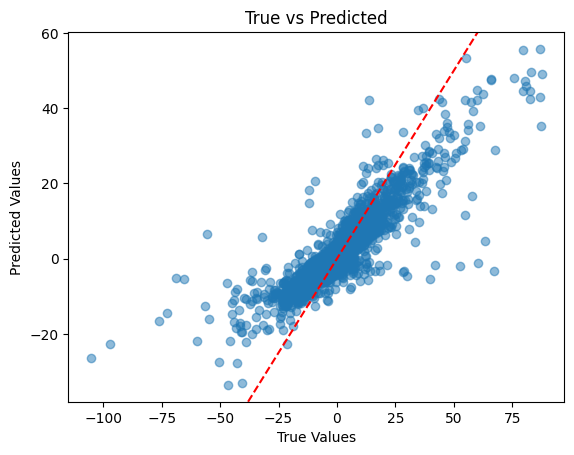

In [10]:
###########################################
# PERFORMANCE METRICS
###########################################

# Predict on test set
y_pred = best_xgb.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

# Check basic distribution of y_test
print("Mean of y_test:", np.mean(y_test))
print("Std of y_test:", np.std(y_test))

# Compare to model predictions
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted")
plt.axline((0, 0), slope=1, color='red', linestyle='--')
plt.show()



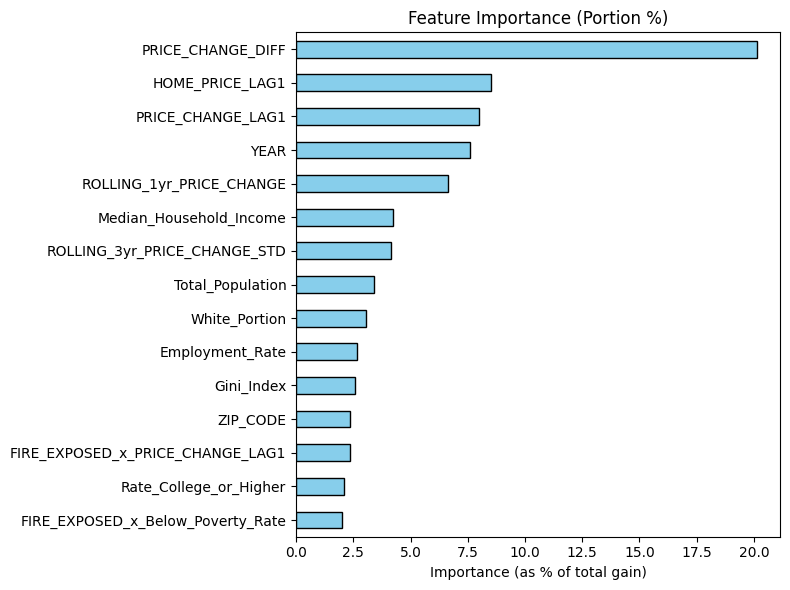

In [11]:
###########################################
# FEATURE IMPORTANCE
###########################################

from xgboost import plot_importance
import matplotlib.pyplot as plt
import pandas as pd

# Get raw importance scores (gain)
raw_importance = best_xgb.get_booster().get_score(importance_type='gain')

# Convert to DataFrame and compute percentage
importance_df = pd.DataFrame.from_dict(raw_importance, orient='index', columns=['Gain'])
importance_df['Portion (%)'] = 100 * importance_df['Gain'] / importance_df['Gain'].sum()

# Sort and plot top 15
top_features = importance_df.sort_values('Portion (%)', ascending=False).head(15)

# Plot
top_features['Portion (%)'].plot(kind='barh', figsize=(8, 6), color='skyblue', edgecolor='black')
plt.title('Feature Importance (Portion %)')
plt.xlabel('Importance (as % of total gain)')
plt.gca().invert_yaxis()  # Highest at top
plt.tight_layout()
plt.show()


